In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from category_encoders import MEstimateEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id',na_values='NA',keep_default_na=False)
X_test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id',na_values='NA',keep_default_na=False)

In [4]:
X=pd.concat([X_train.drop(['SalePrice'],axis=1),X_test],axis=0)
y=X_train['SalePrice']

In [5]:
num_data=X.select_dtypes(exclude=['object']).drop(['MSSubClass'],axis=1).copy()
cat_data=X.select_dtypes(include=['object']).copy()
cat_data['MSSubClass']=X['MSSubClass'].copy()

In [6]:
disc_num_cols = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_cols=[]
for i in num_data.columns:
    if i not in disc_num_cols:
        cont_num_cols.append(i)

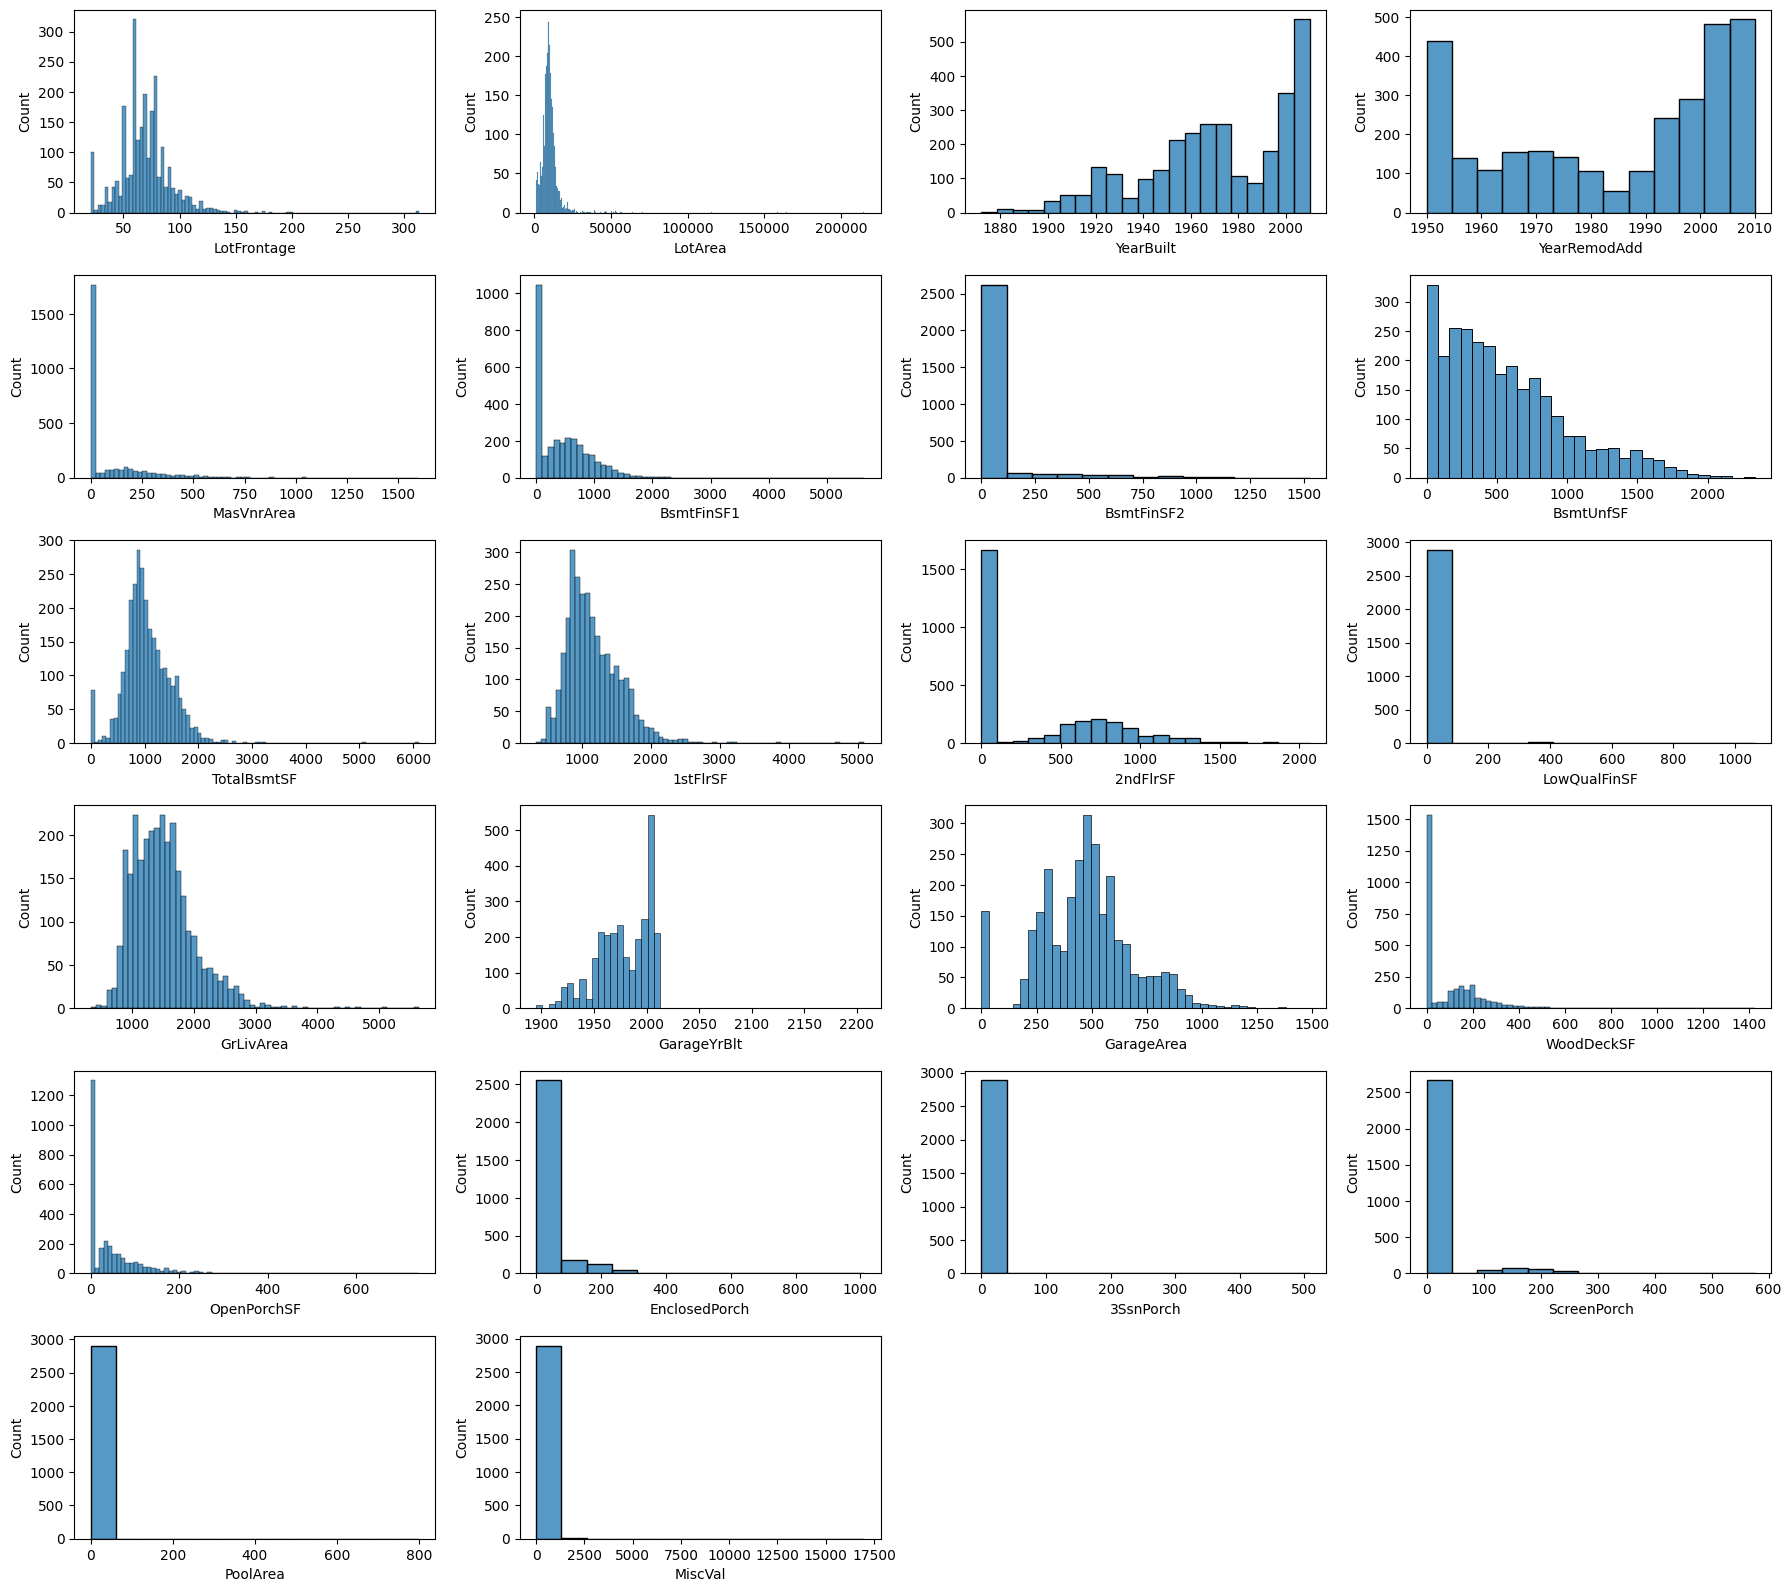

In [7]:
fig=plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_cols):
    plt.subplot(6,4,index+1)
    sns.histplot(num_data.loc[:,col].dropna(),kde=False)

fig.tight_layout(pad=1.0)

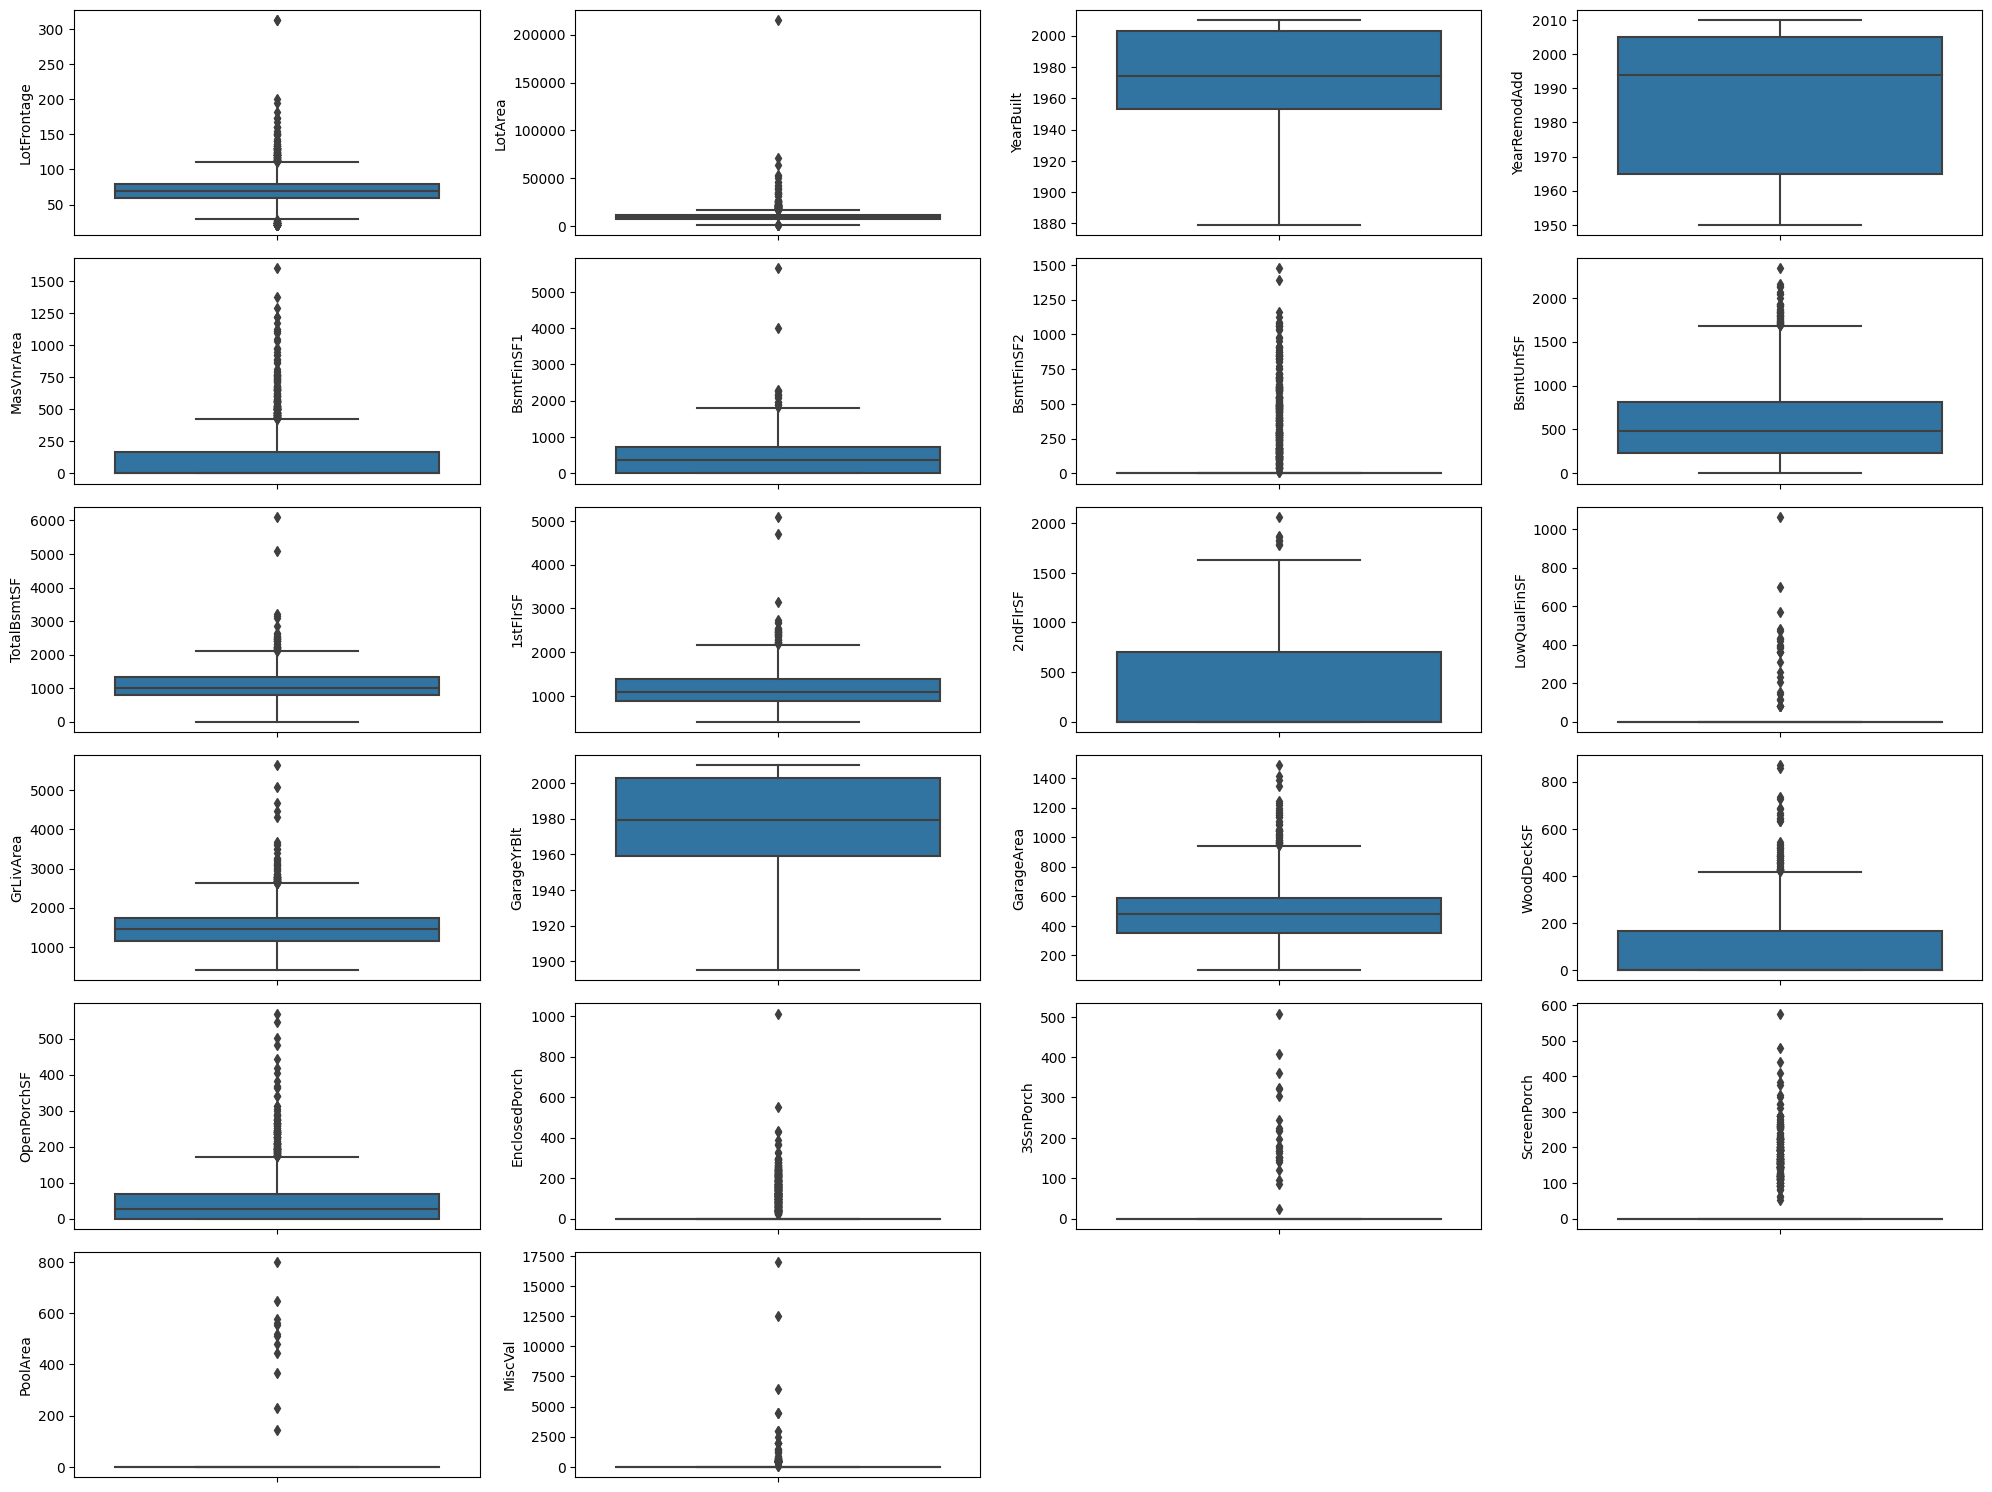

In [8]:
fig=plt.figure(figsize=(20,15))
for index,col in enumerate(cont_num_cols):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col,data=num_data.dropna())
    
fig.tight_layout(pad=1.0)

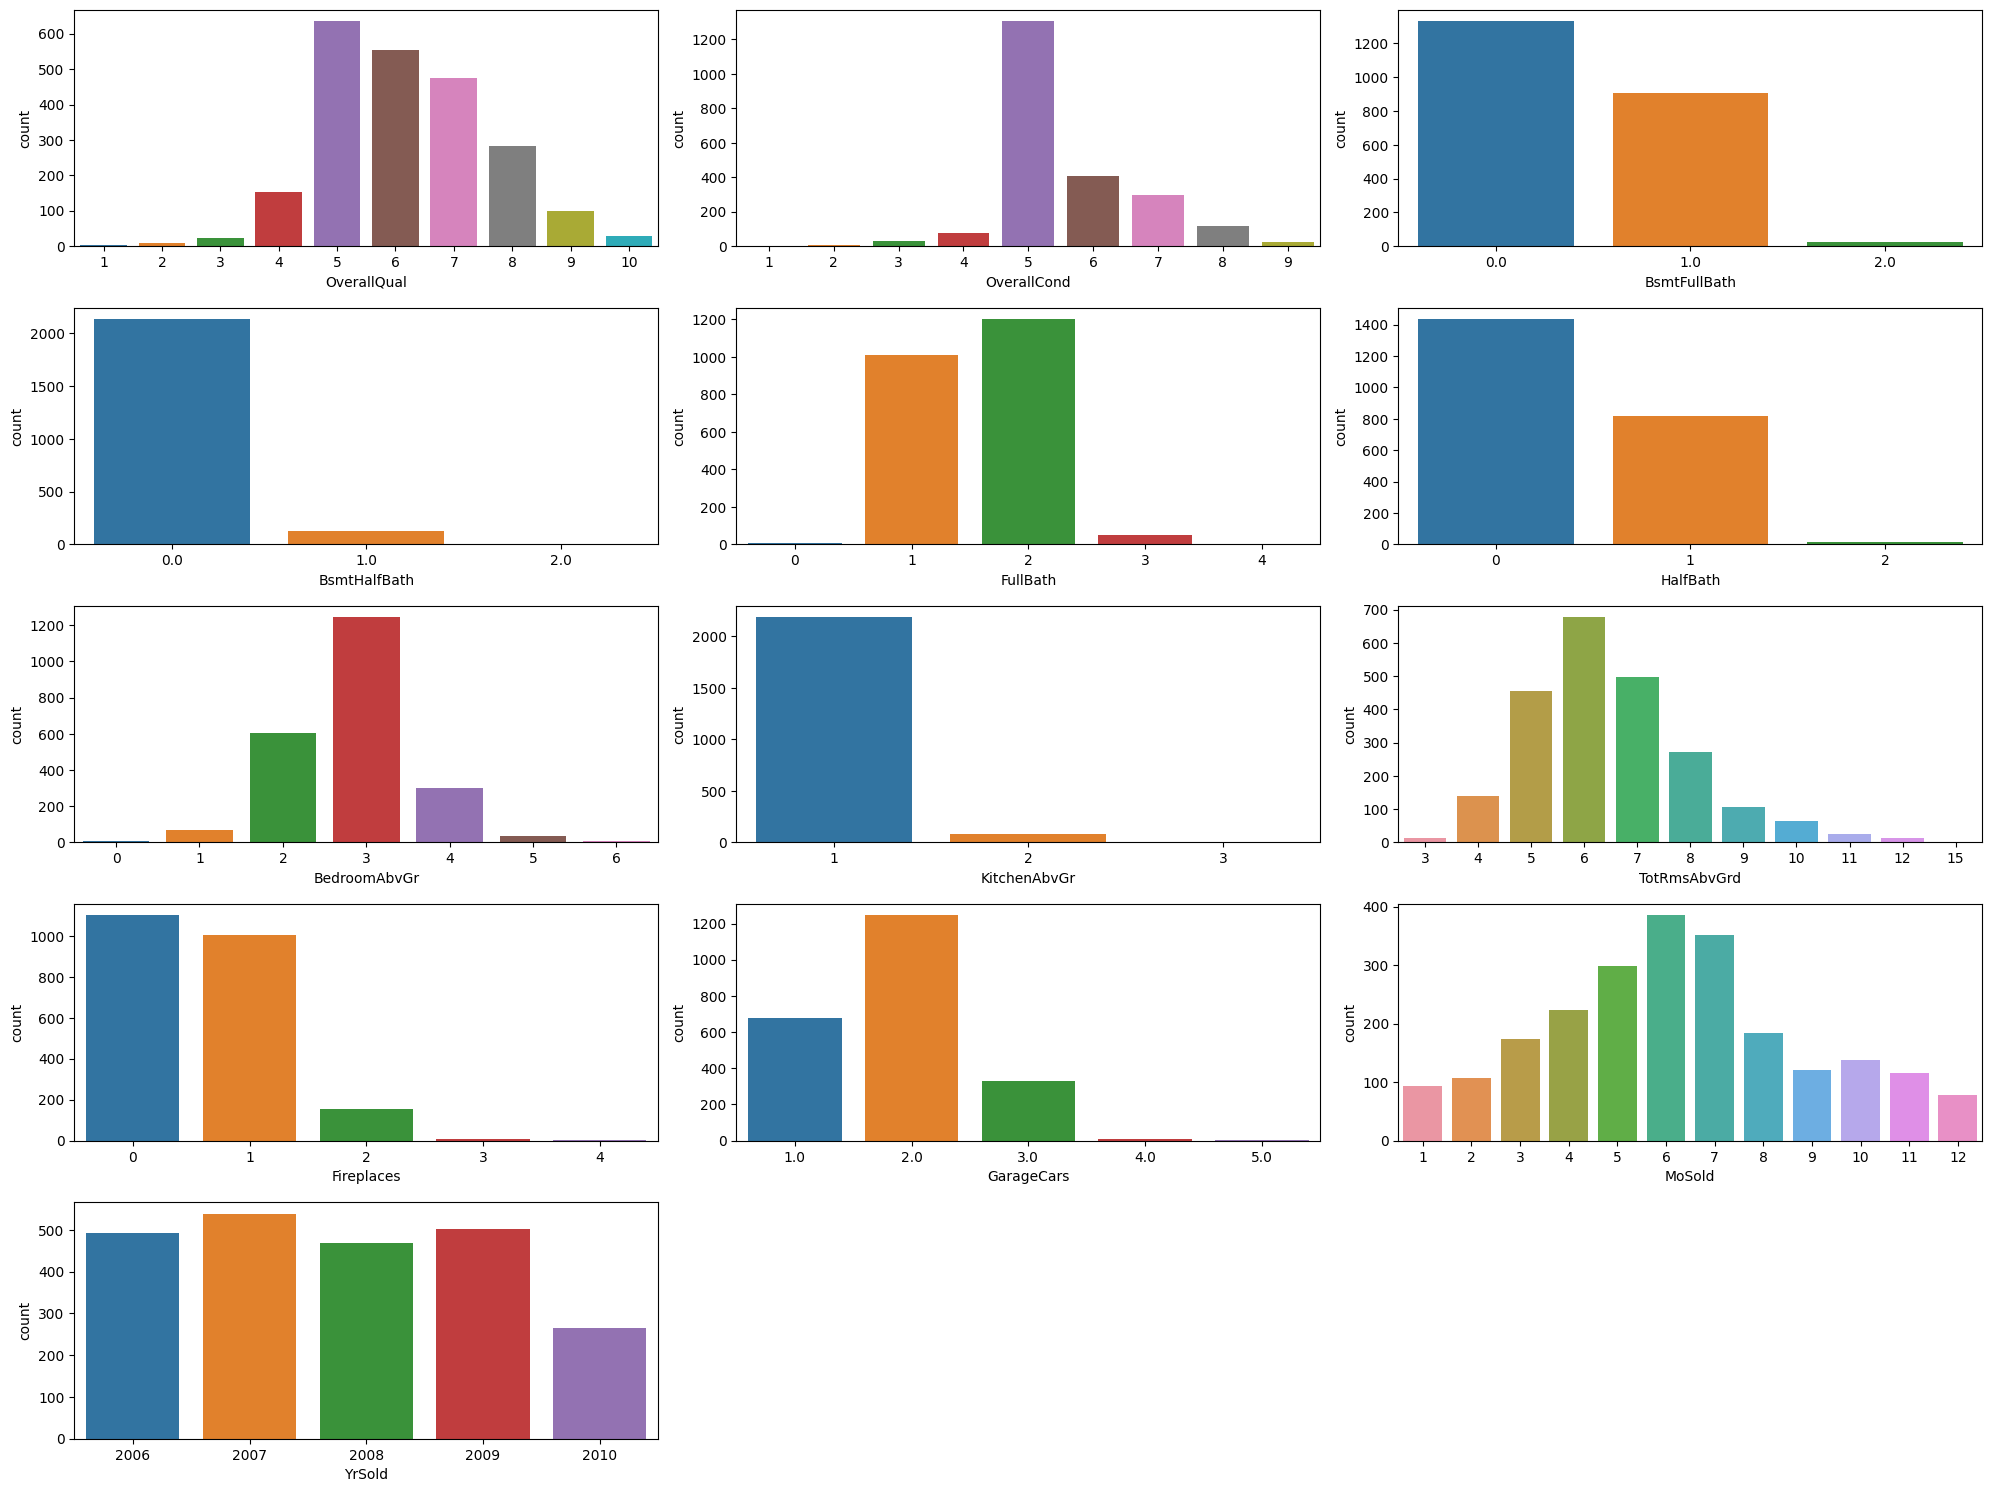

In [9]:
fig=plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_cols):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=num_data.dropna())
    
fig.tight_layout(pad=1.0)

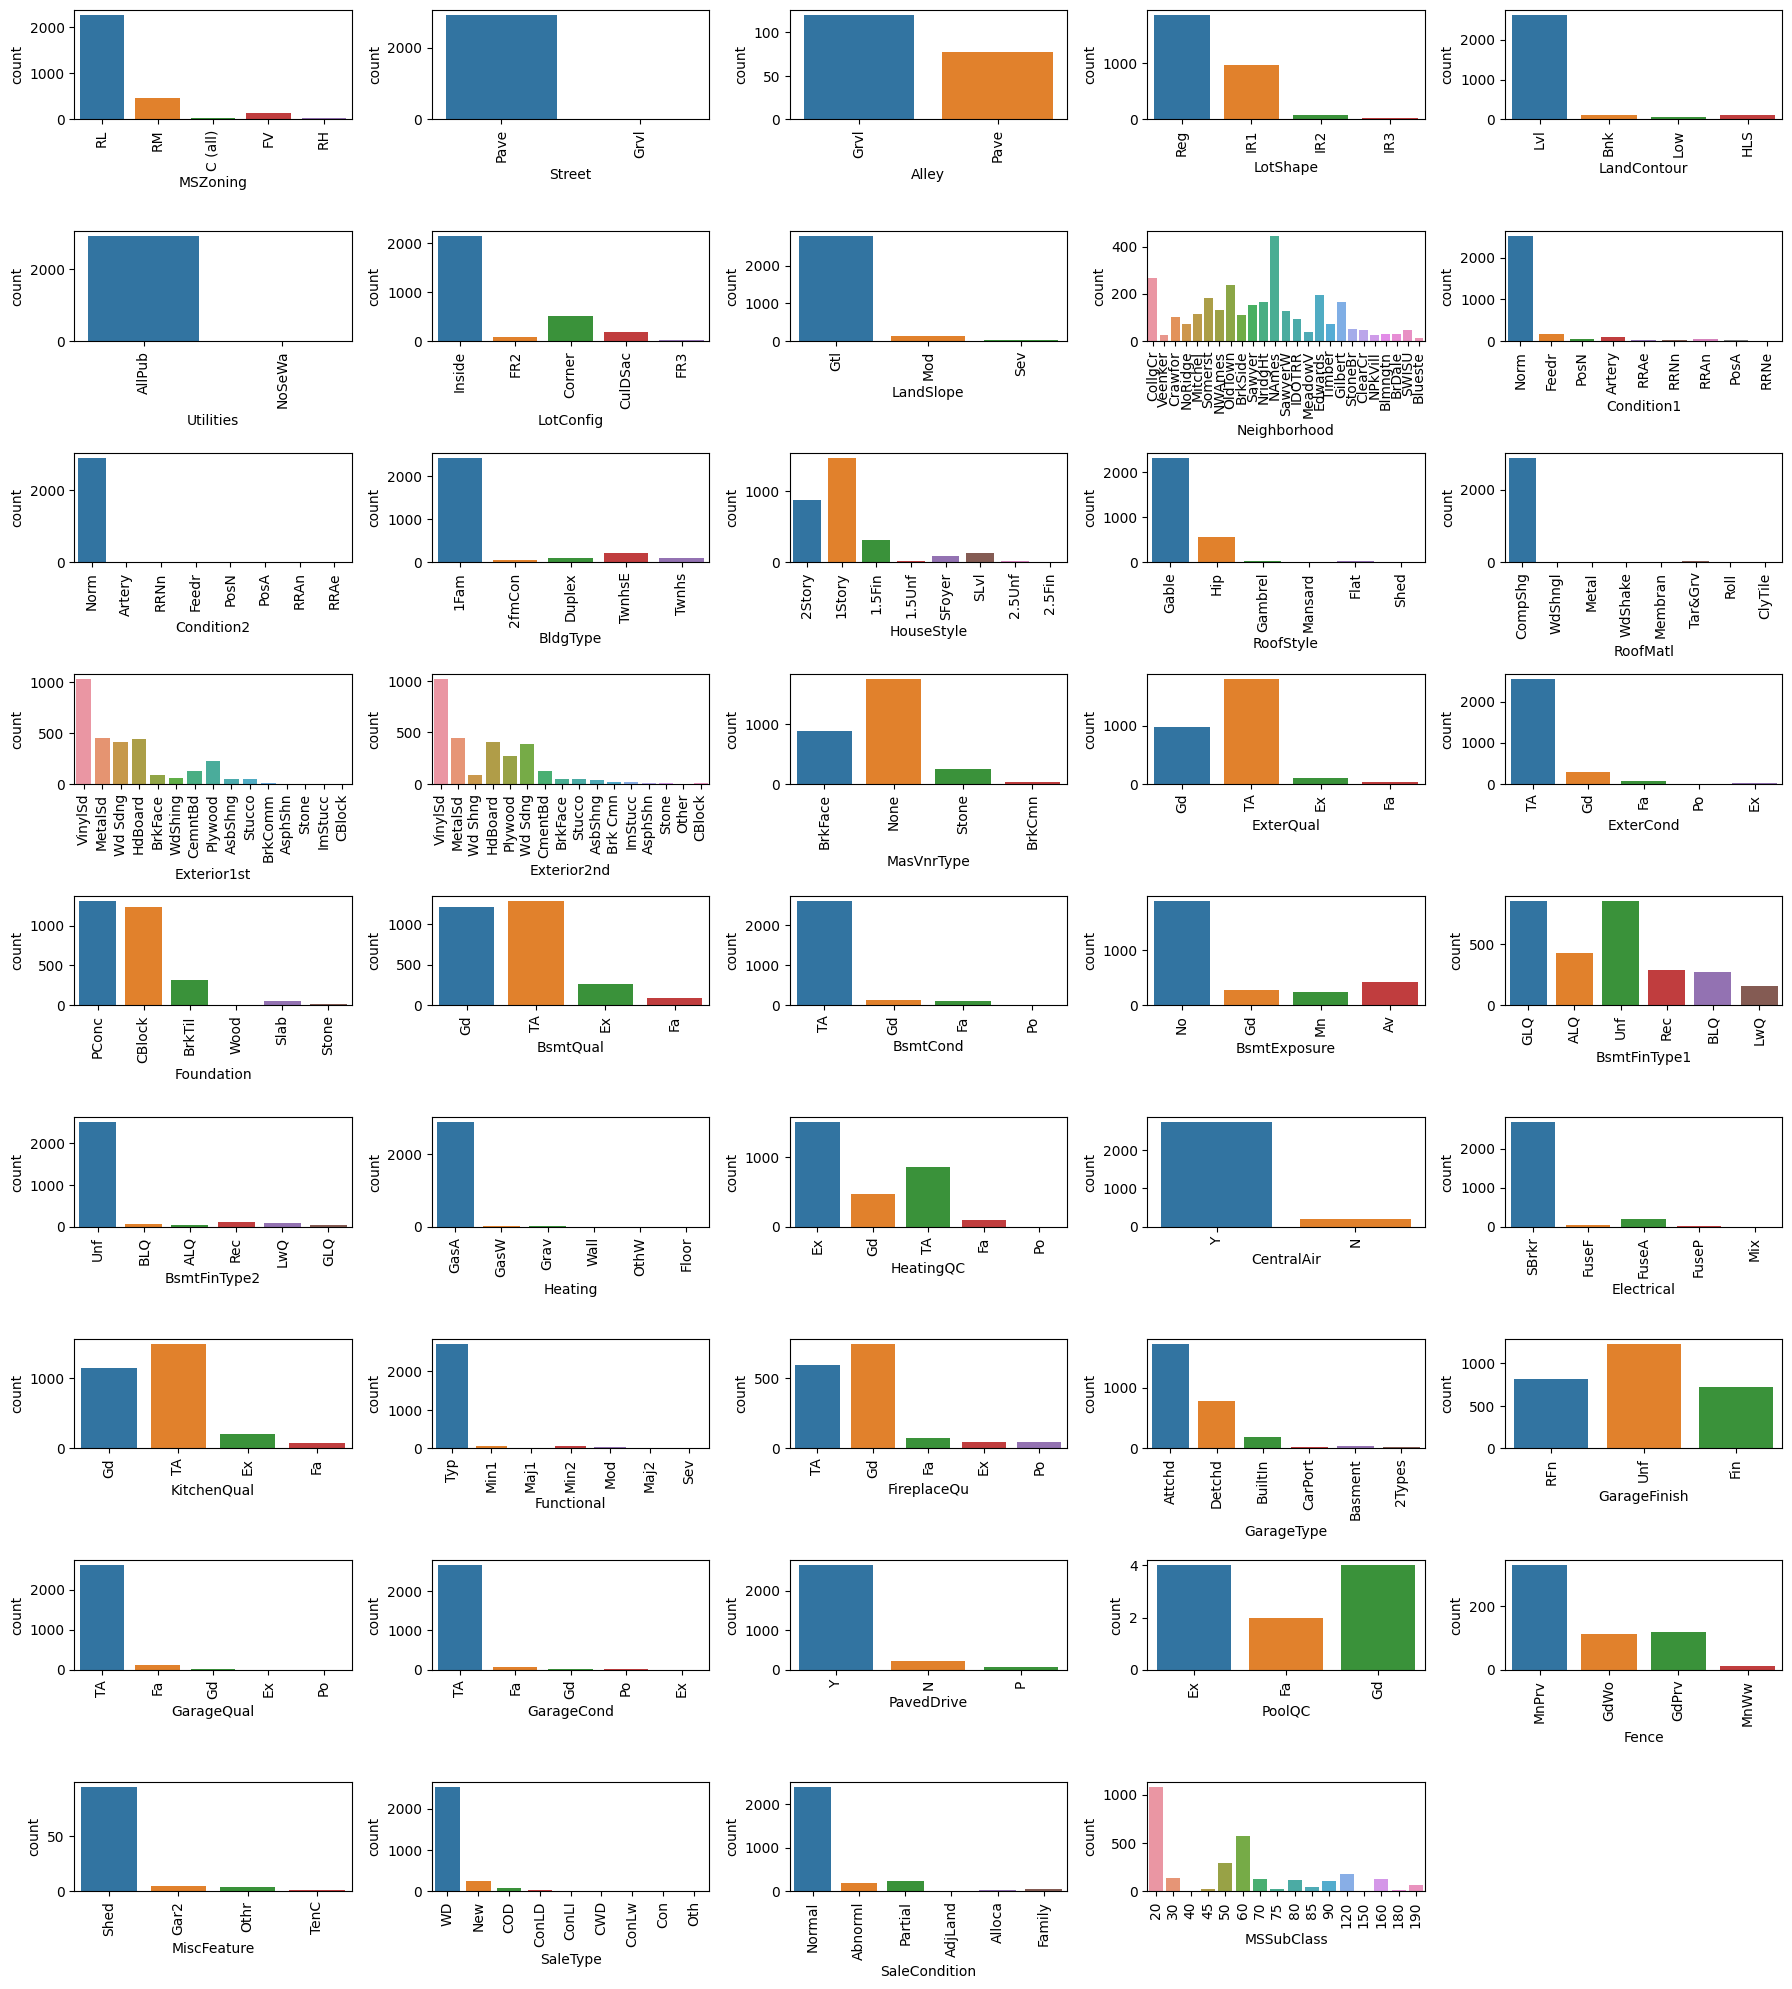

In [10]:
fig=plt.figure(figsize=(18,20))
for index in range(len(cat_data.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_data.iloc[:,index],data=cat_data.dropna())
    plt.xticks(rotation=90)
    
fig.tight_layout(pad=1.0)

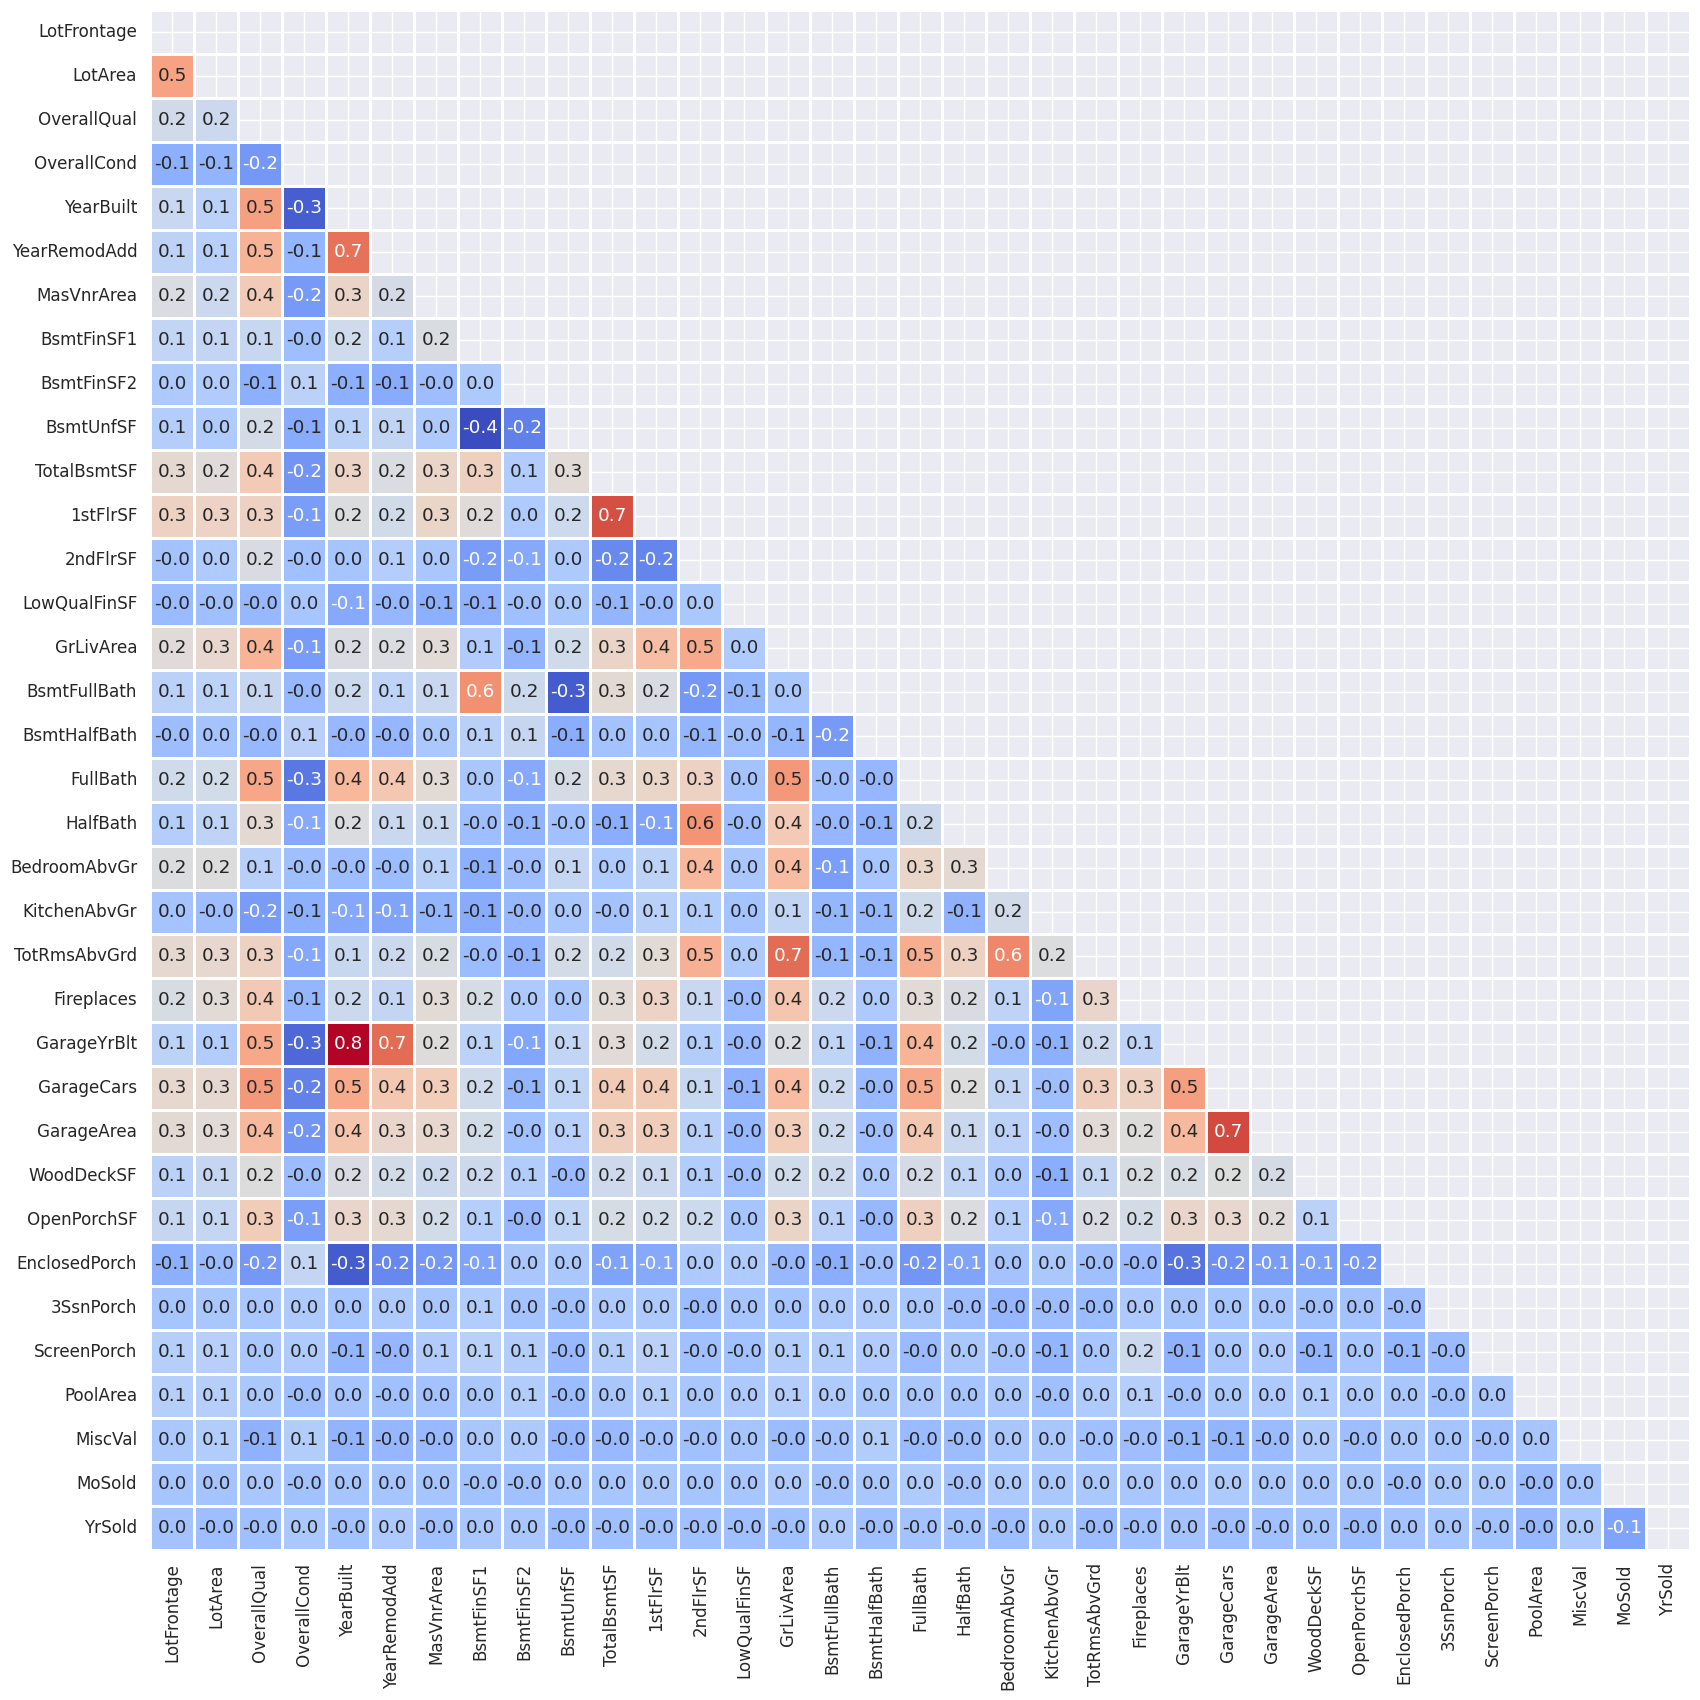

In [11]:
sns.set(font_scale=1.1)
correlation = num_data.corr(method='kendall')
mask = np.triu(correlation.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
#             mask=correlation<0.8,
            linewidths=1,
            cbar=False)

plt.show()

In [12]:
num_train=X_train.select_dtypes(exclude=['object']).copy()
correlation=num_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'],ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


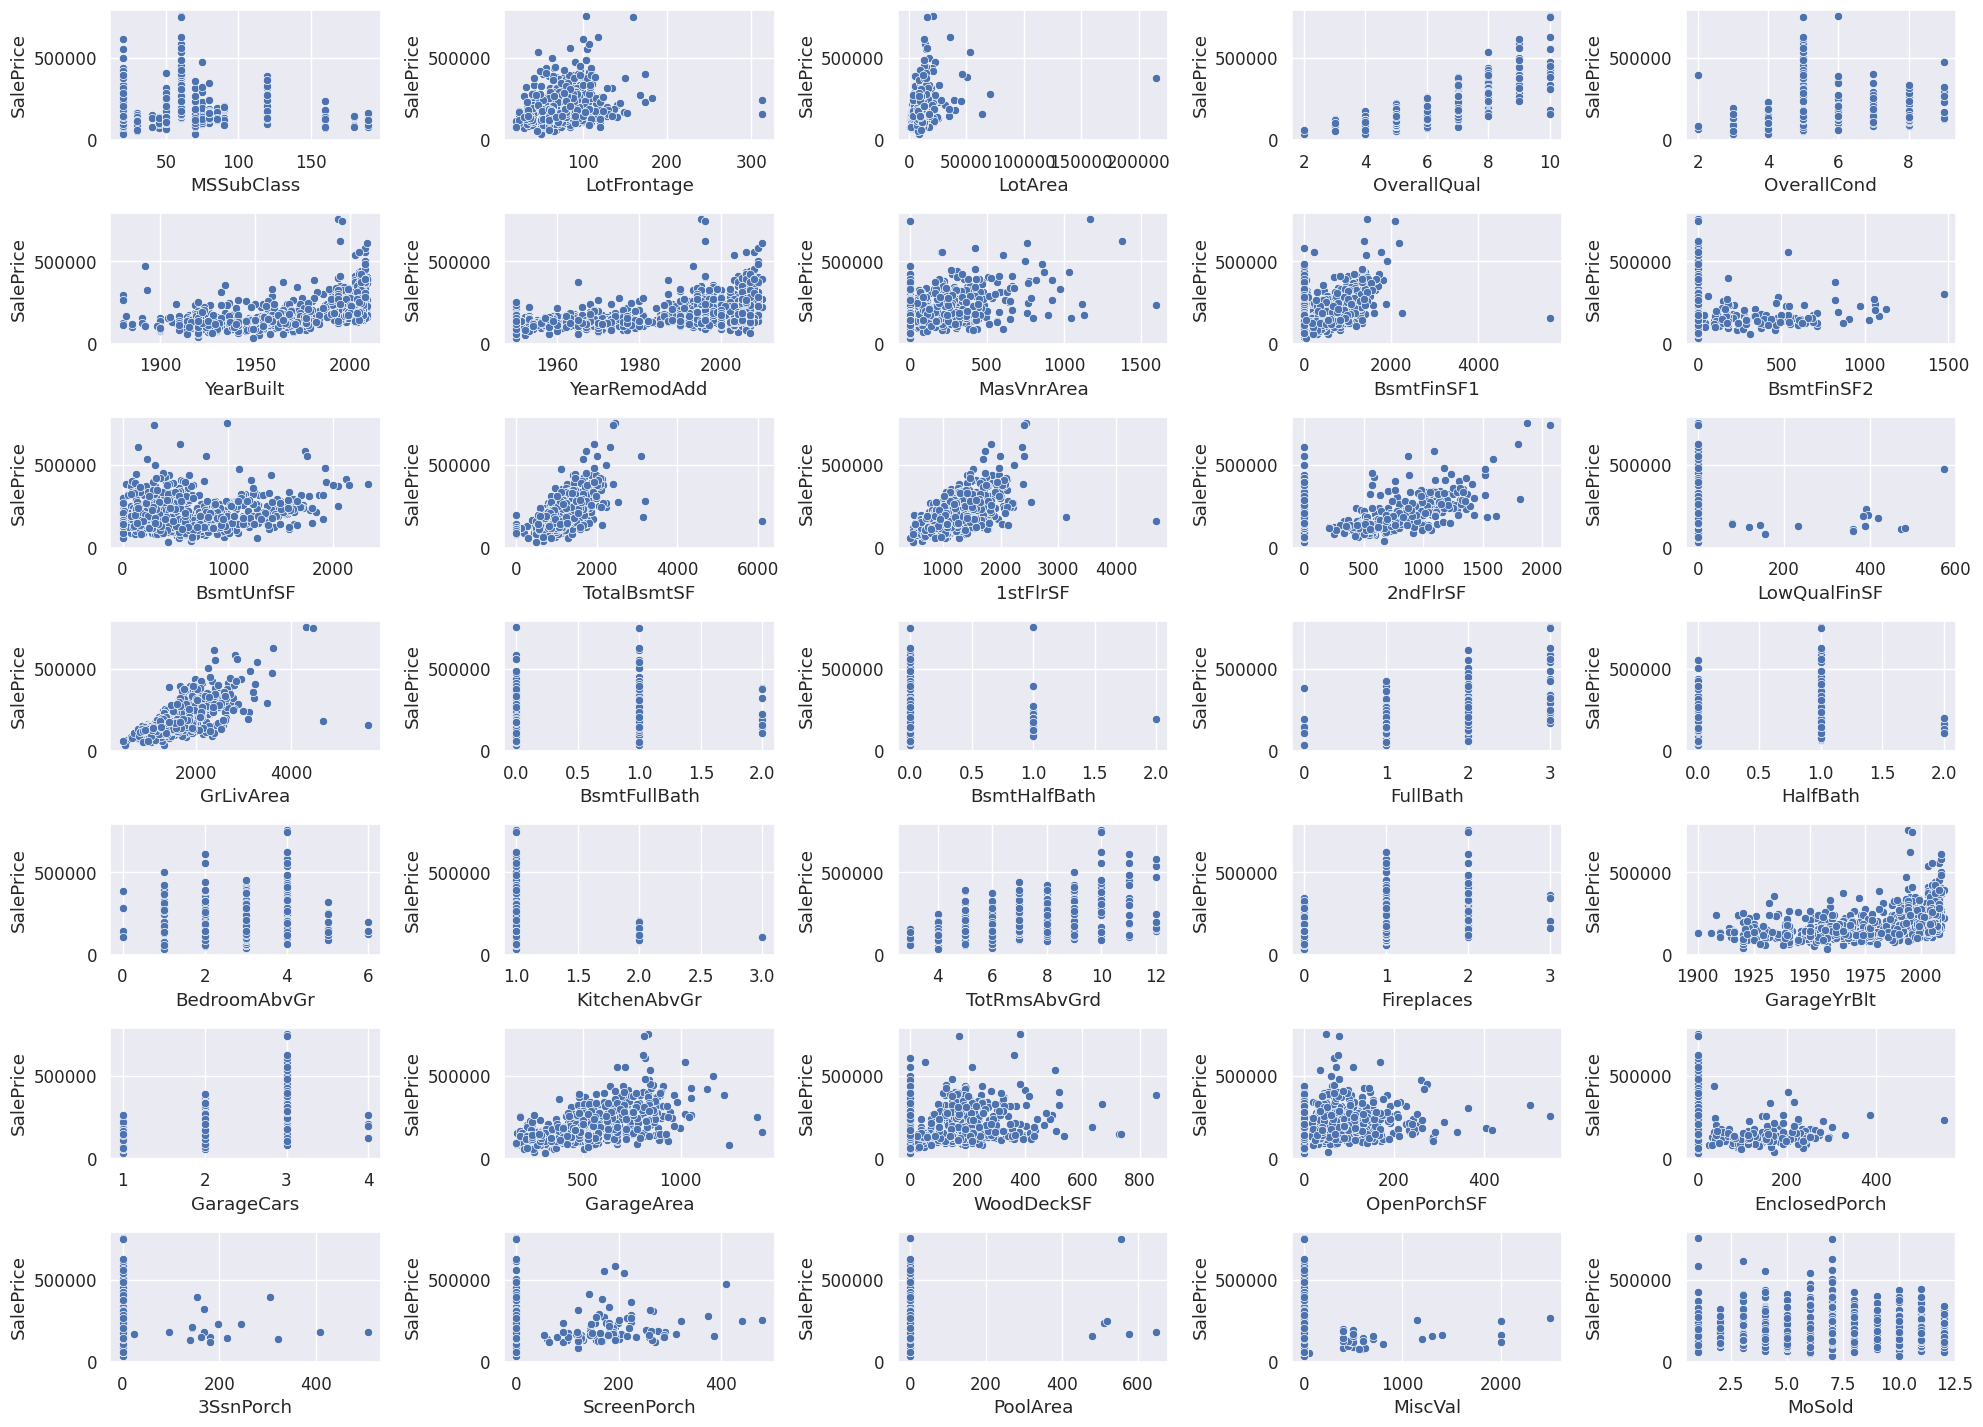

In [13]:
fig=plt.figure(figsize=(20,20))
for index in range(len(num_data.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=num_train.iloc[:,index],y='SalePrice',data=num_train.dropna())
    
fig.tight_layout(pad=1.0)

<Axes: title={'center': 'Number of missing values'}, ylabel='sum'>

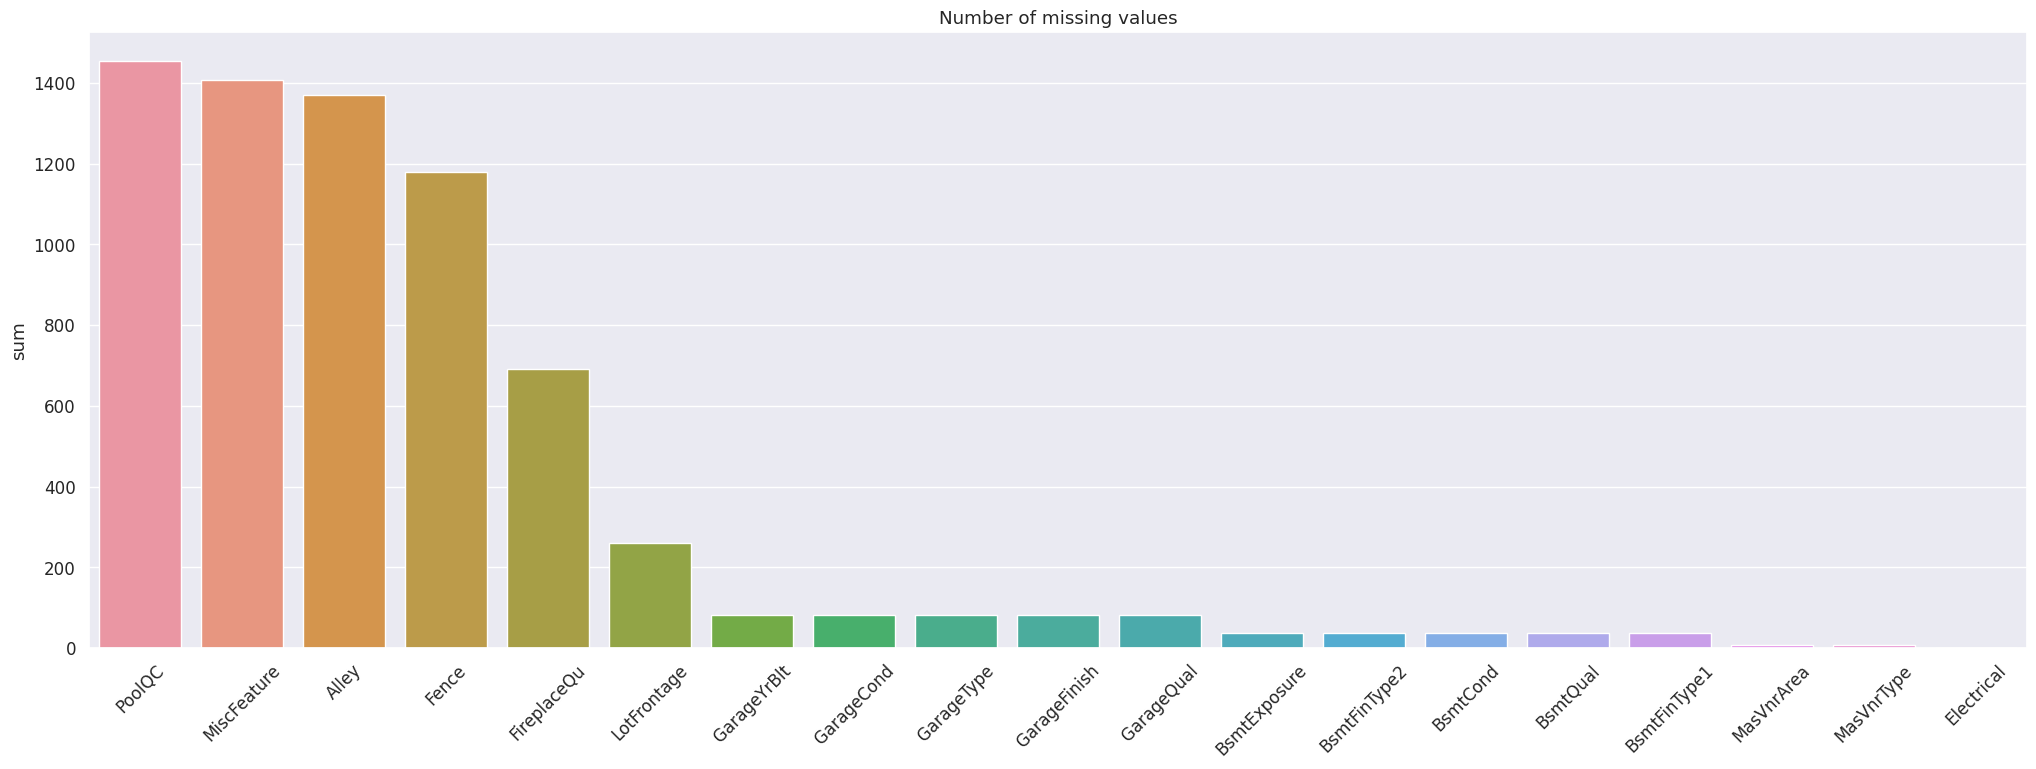

In [14]:
fig=plt.figure(figsize=(25,8))
plt.title('Number of missing values')
missing_count = pd.DataFrame(X_train.isnull().sum(),columns=['sum']).sort_values(by=['sum'],ascending=False)
missing_count = missing_count.loc[missing_count['sum'] > 0]
plt.xticks(rotation=45)
sns.barplot(x=missing_count.index,y='sum',data=missing_count)

In [15]:
def drop_cols(data):
    df=data.copy()
#     redundant features - feature with multicollinearity pinpointed from the corredlation matrix
    df.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)
#     features with too much N/A value
#     df.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)
#     useless features-have no linear realationship with the target
#     pointout from scatter plot and correlation score of the target
    df.drop(['MoSold','YrSold'], axis=1, inplace=True)
#     correlation[['SalePrice']].sort_values(['SalePrice'],ascending=False).tail(10)
#     features with mostly 1 value
    cat_col = df.select_dtypes(include=['object']).drop(['MSSubClass'], axis=1).columns
    overfit_cat = []
    for i in cat_col:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 96:
            overfit_cat.append(i)

    overfit_cat = list(overfit_cat)
    df.drop(overfit_cat, axis=1,inplace=True)

    num_col = df.select_dtypes(exclude=['object']).columns
    overfit_num = []
    for i in num_col:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 96:
            overfit_num.append(i)

    overfit_num = list(overfit_num)
    df.drop(overfit_num, axis=1,inplace=True)
    
    return df

In [16]:
from sklearn.impute import KNNImputer

def fill_missing_value(data):
    df=data.copy()
    
    ord_cols = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
           'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
           "HeatingQC",'ExterQual','ExterCond',"Alley", "PoolQC", "MiscFeature"]
    df[ord_cols] = df[ord_cols].fillna("None")
    
#     fill with most occurent
    cat_cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
    df[cat_cols] = df.groupby("Neighborhood")[cat_cols].transform(lambda x: x.fillna(x.mode()[0]))

    
    df['LotFrontage']=df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
    df['GarageArea']=df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
    df['MSZoning']=df.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
                                                                              
    cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
    df[cont] = df[cont].fillna(df[cont].mean())
    
    return df

In [17]:
def ordinal_encode(data):
    df=data.copy()
    ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
    fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
    expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
    fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

    ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
    for col in ord_col:
        df[col] = df[col].map(ordinal_map)

    fin_col = ['BsmtFinType1','BsmtFinType2']
    for col in fin_col:
        df[col] = df[col].map(fintype_map)

    df['BsmtExposure'] = df['BsmtExposure'].map(expose_map)
    df['Fence'] = df['Fence'].map(fence_map)
    
    return df

In [18]:
def feature_engineering(data,dummies=False):
    df=data.copy()
    df['TotalLot'] = df['LotFrontage'] + df['LotArea']
    df['TotalBsmtFin'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['TotalSF'] = df['TotalBsmtSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + df['HalfBath']
    df['TotalPorch'] = df['OpenPorchSF'] + df['ScreenPorch']
    
    colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

    for col in colum:
        col_name = col+'_bin'
        df[col_name] = df[col].apply(lambda x: 1 if x > 0 else 0)
                
    if dummies==True:
        df = pd.get_dummies(df,dtype='uint8')
    
    return df

In [19]:
def remove_outlier(data):
    df=data.copy()
    # remove outlier pointout from boxplot

    df = df.drop(df[df['LotFrontage'] > 200].index)
    df = df.drop(df[df['LotArea'] > 100000].index)
    df = df.drop(df[df['BsmtFinSF1'] > 4000].index)
    df = df.drop(df[df['TotalBsmtSF'] > 5000].index)
    df = df.drop(df[df['GrLivArea'] > 4000].index)
    df = df.drop(df[(df['OverallQual']>9) & (df['SalePrice']<220000)].index)
#     df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
    return df

In [20]:
def Scale_value(x1,x2,x3):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    cols = X1.select_dtypes(np.number).columns
#     scaler = StandardScaler()
    scaler = RobustScaler()
    X1[cols]=scaler.fit_transform(X1[cols])
    X2[cols]=scaler.transform(X2[cols])
    X3[cols]=scaler.transform(X3[cols])
    return X1,X2,X3

In [21]:
def get_target_encode(x1,y1,x2,x3,cols):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    X1=X1.astype('object')
    X2=X2.astype('object')
    X3=X3.astype('object')
    
    encoder = MEstimateEncoder(m=5.0)
    X1_target_encode_1=encoder.fit_transform(X1.loc[:,cols],y1).rename(columns=lambda col: 'Target_encode_1_' + col,inplace=False)
    X2_target_encode_1=encoder.transform(X2.loc[:,cols]).rename(columns=lambda col: 'Target_encode_1_' + col,inplace=False)
    X3_target_encode_1=encoder.transform(X3.loc[:,cols]).rename(columns=lambda col: 'Target_encode_1_' + col,inplace=False)
    
    encoder = TargetEncoder(smoothing=1.0)
    X1_target_encode_2=encoder.fit_transform(X1.loc[:,cols],y1).rename(columns=lambda col: 'Target_encode_2_' + col,inplace=False)
    X2_target_encode_2=encoder.transform(X2.loc[:,cols]).rename(columns=lambda col: 'Target_encode_2_' + col,inplace=False)
    X3_target_encode_2=encoder.transform(X3.loc[:,cols]).rename(columns=lambda col: 'Target_encode_2_' + col,inplace=False)
    
    df1 = pd.concat([X1_target_encode_1,X1_target_encode_2],axis=1)
    df2 = pd.concat([X2_target_encode_1,X2_target_encode_2],axis=1)
    df3 = pd.concat([X3_target_encode_1,X3_target_encode_2],axis=1)
    return df1,df2,df3

In [22]:
def get_pca_transform(x1,x2,x3,n_components):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    cols = X1.select_dtypes(np.number).columns
    X1,X2,X3=Scale_value(X1.loc[:,cols],X2.loc[:,cols],X3.loc[:,cols])
    
    encoder = PCA(n_components=n_components)
    X1_pca=pd.DataFrame(encoder.fit_transform(X1.loc[:,cols]),columns=['Pca_'+str(i) for i in range(n_components)],index=X1.index)
    X2_pca=pd.DataFrame(encoder.transform(X2.loc[:,cols]),columns=['Pca_'+str(i) for i in range(n_components)],index=X2.index)
    X3_pca=pd.DataFrame(encoder.transform(X3.loc[:,cols]),columns=['Pca_'+str(i) for i in range(n_components)],index=X3.index)

    return X1_pca,X2_pca,X3_pca

In [23]:
def get_kmean_cluster(x1,x2,x3,n_estimators=20):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    cols = X1.select_dtypes(np.number).columns
    encoder = KMeans(n_clusters=n_estimators, n_init=10, random_state=7)
    X1_cd=pd.DataFrame(encoder.fit_predict(X1.loc[:,cols]),columns=['Kmean'],index=X1.index)
    X2_cd=pd.DataFrame(encoder.predict(X2.loc[:,cols]),columns=['Kmean'],index=X2.index)
    X3_cd=pd.DataFrame(encoder.predict(X3.loc[:,cols]),columns=['Kmean'],index=X3.index)
    
    return X1_cd,X2_cd,X3_cd

In [24]:
def Onehot_transform(x1,x2,x3,cols):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    tmp=encoder.fit_transform(X1.loc[:,cols])
    X1=pd.DataFrame(encoder.fit_transform(X1.loc[:,cols]).toarray(),columns=encoder.get_feature_names_out(cols),index=X1.index)
    X2=pd.DataFrame(encoder.transform(X2.loc[:,cols]).toarray(),columns=encoder.get_feature_names_out(cols),index=X2.index)
    X3=pd.DataFrame(encoder.transform(X3.loc[:,cols]).toarray(),columns=encoder.get_feature_names_out(cols),index=X3.index)
    
    return X1,X2,X3

In [25]:
def mi_score_filter(x1,y1,x2,x3):
    X1=x1.copy()
    X2=x2.copy()
    X3=x3.copy()
    
    mi_scores = mutual_info_regression(X1, y1, discrete_features=False, random_state=7)
    indices = np.where(mi_scores>=0.05)[0]
    return X1.iloc[:,indices],X2.iloc[:,indices],X3.iloc[:,indices]

In [26]:
def preprocess_data(X1,y1,X2,X3):
#     onehot mi_score select only?
    X1_num,X2_num,X3_num=X1.select_dtypes(exclude=['object']),X2.select_dtypes(exclude=['object']),X3.select_dtypes(exclude=['object'])
    X1_onehot,X2_onehot,X3_onehot=Onehot_transform(X1,X2,X3,categorical_cols)
    X1_kmean,X2_kmean,X3_kmean = get_kmean_cluster(X1,X2,X3)
    
    X1_target_encode,X2_target_encode,X3_target_encode = get_target_encode(X1,y1,X2,X3,categorical_cols)
    X1_kmean_target_encode,X2_kmean_target_encode,X3_kmean_target_encode = get_target_encode(X1_kmean,y1,X2_kmean,X3_kmean,X1_kmean.columns)
    X1_pca,X2_pca,X3_pca=get_pca_transform(X1,X2,X3,50)
    
    df1=pd.concat([X1_onehot,X1_target_encode,X1_pca,X1_kmean,X1_kmean_target_encode,X1_num],axis=1)
    df2=pd.concat([X2_onehot,X2_target_encode,X2_pca,X2_kmean,X2_kmean_target_encode,X2_num],axis=1)
    df3=pd.concat([X3_onehot,X3_target_encode,X3_pca,X3_kmean,X3_kmean_target_encode,X3_num],axis=1)

#     df1,df2,df3=mi_score_filter(df1,y1,df2,df3)
    df1 = pd.get_dummies(df1)
    df2 = pd.get_dummies(df2)
    df1,df2,df3=Scale_value(df1,df2,df3)
    return df1,df2,df3

In [27]:
X['MSSubClass'] = X['MSSubClass'].apply(str)
X=drop_cols(X)
X_train=remove_outlier(X_train)
X=fill_missing_value(X)

# mi_scores = mutual_info_regression(X.loc[X_train.index].select_dtypes(np.number), y.loc[X_train.index], discrete_features=False, random_state=7)
# indices = np.where(mi_scores<=0)[0]
# X.drop(X.columns[indices], axis=1, inplace=True)

X=ordinal_encode(X)
X=feature_engineering(X,dummies=True)
categorical_cols=X.select_dtypes(include=['object']).columns

y = np.log(y)

In [28]:
X_train.dropna(axis=0, subset=['SalePrice'], inplace=True)
x = X.loc[X_train.index]
y = y.loc[X_train.index]
X_test = X.loc[X_test.index]

x,X_test,_=Scale_value(x,X_test,X_test)

X_train, X_val, y_train, y_val = train_test_split(x, y, 
                                                      train_size=0.9,
                                                      random_state=7)

In [29]:
# x.to_csv('sample.csv',index=True)

In [30]:
# pca_list
# processed_train,processed_val,processed_test=preprocess_data(X_train,y_train,X_val,X_test)
processed_train,processed_val,processed_test=X_train,X_val,X_test
print(processed_train.shape)
print(y_train.shape)
print(processed_val.shape)
print(y_val.shape)
print(processed_test.shape)

(1305, 235)
(1305,)
(146, 235)
(146,)
(1459, 235)


In [31]:
def score_model(model):
    scores=-1*cross_val_score(model,processed_train,y_train,cv=5,scoring='neg_mean_absolute_error')
    return scores.mean()

In [32]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [33]:
n_iter=100

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')
# param_lst = {
#     'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
#     'n_estimators' : [100, 500, 1000, 2000, 3000],
#     'max_depth' : [3, 6, 9],
#     'min_child_weight' : [1, 5, 10, 20],
#     'reg_alpha' : [0.001, 0.01, 0.1],
#     'reg_lambda' : [0.001, 0.01, 0.1]
# }

# xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
#                               n_iter = n_iter, scoring = 'neg_root_mean_squared_error',
#                               cv = 5)
       
# xgb_search = xgb_reg.fit(processed_train, y_train)

# best_param = xgb_search.best_params_
best_param={'reg_lambda': 0.1,
            'reg_alpha': 0.1,
            'n_estimators': 2000,
            'min_child_weight': 10,
            'max_depth': 3,
            'learning_rate': 0.01}

xgb = XGBRegressor(**best_param)
print(best_param)

{'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.01}


In [35]:
xgb.fit(processed_train, y_train,
        verbose=False)
preds = xgb.predict(processed_val)

score = mean_absolute_error(y_val, preds)
print('MAE:', score)

MAE: 0.08488929956472945


In [36]:
%%capture
lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=20, 
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1)

param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = n_iter, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
lightgbm_search = lightgbm.fit(processed_train, y_train)

best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

In [37]:
print(best_param)

{'n_estimators': 1000, 'min_child_samples': 5, 'max_depth': 2, 'learning_rate': 0.1, 'lambda_l2': 0.01, 'lambda_l1': 0.01, 'feature_fraction': 0.8}


In [38]:
lgbm.fit(processed_train, y_train,
        verbose=False)
preds = lgbm.predict(processed_val)

score = mean_absolute_error(y_val, preds)
print('MAE lgbm:', score)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


MAE lgbm: 0.08900196952355933


In [39]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
                              n_iter = n_iter, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

catboost_search = catboost.fit(processed_train, y_train)

best_param = catboost_search.best_params_
cb = CatBoostRegressor(**best_param)
print(best_param)

{'rsm': 0.7, 'random_strength': 1, 'n_estimators': 1600, 'min_child_samples': 20, 'max_depth': 6, 'learning_rate': 0.01, 'l2_leaf_reg': 0.001}


In [40]:
cb.fit(processed_train, y_train,
        verbose=False)
preds = cb.predict(processed_val)

score = mean_absolute_error(y_val, preds)
print('MAE cb:', score)

MAE cb: 0.08250699586994294


In [41]:
def blend_models_predict(X,model,weight):
    res=0
    for i in range(len(model)):
        res=res+weight[i]*model[i].predict(X)
    return res

In [42]:
processed_train.dropna().shape

(115, 235)

In [43]:
from mlxtend.regressor import StackingCVRegressor
stack_model = StackingCVRegressor(regressors=(xgb,cb,lgbm),
                                meta_regressor=xgb,
                                use_features_in_secondary=True)
# stack_model.fit(processed_train,y_train)

In [44]:
model_list=[xgb,cb,lgbm]
weight_list=[0.4,0.3,0.3]

In [45]:
pred_val=blend_models_predict(processed_val, model_list,weight_list)

score = mean_absolute_error(y_val, pred_val)
print('MEA val:', score)

MEA val: 0.08354320995441528


In [46]:
preds_test = np.exp(blend_models_predict(processed_test, model_list,weight_list))
print(preds_test)
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

[130362.23773385 161478.47523921 189124.41119781 ... 168051.06483181
 122429.86890668 210199.38477804]
